In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc,
    PrecisionRecallDisplay, RocCurveDisplay
)
import os
import json
import joblib
import pandas as pd
from datetime import datetime
import optuna

c:\Users\sam\anaconda3\envs\API\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# 查看數據的前幾行
print(train_data.head())
print(test_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

訓練集形狀: (891, 12)
測試集形狀: (418, 11)

訓練集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

測試集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  


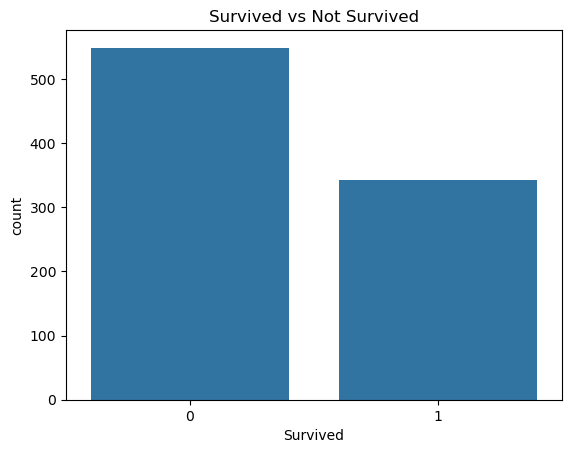

In [15]:
# 數據探索
print("訓練集形狀:", train_data.shape)
print("測試集形狀:", test_data.shape)
print("\n訓練集信息:")
print(train_data.info())
print("\n測試集信息:")
print(test_data.info())

# 查看缺失值
print("\n訓練集缺失值:")
print(train_data.isnull().sum())
print("\n測試集缺失值:")
print(test_data.isnull().sum())

# 可視化生還比例
sns.countplot(x='Survived', data=train_data)
plt.title('Survived vs Not Survived')
plt.show()

In [16]:
# 處理缺失值
# 填充年齡的中位數
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

# 填充登船港口的最常見值
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

# 刪除 Cabin 特徵（缺失值過多）
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

# 創建新特徵：家庭大小
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

# 創建新特徵：是否獨自旅行
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

# 刪除不必要的特徵
train_data.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)

C:\Users\sam\AppData\Local\Temp\ipykernel_5332\2593712799.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
C:\Users\sam\AppData\Local\Temp\ipykernel_5332\2593712799.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [17]:
print("訓練集形狀:", train_data.shape)
print("測試集形狀:", test_data.shape)

訓練集形狀: (891, 8)
測試集形狀: (418, 7)


In [18]:
# 定義數值型和類別型特徵
numerical_features = ['Age', 'Fare', 'FamilySize', 'IsAlone']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# 創建預處理管道
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# 分離特徵和目標變量
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

Logistic Regression K-Fold Cross-validation Accuracy: 0.8047


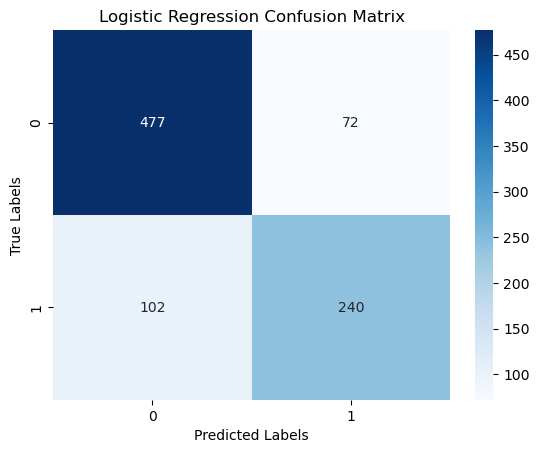

<Figure size 640x480 with 0 Axes>

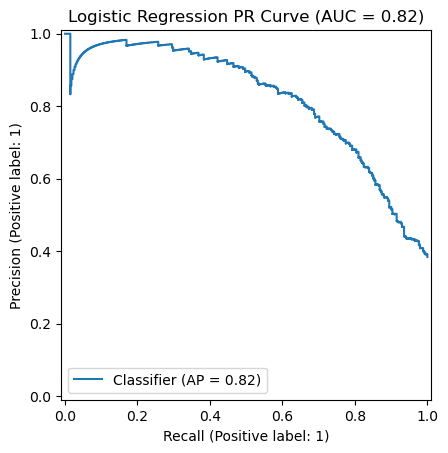

<Figure size 640x480 with 0 Axes>

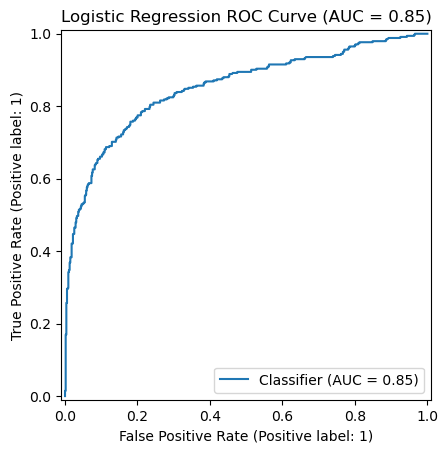


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       549
           1       0.77      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891

Decision Tree K-Fold Cross-validation Accuracy: 0.7710


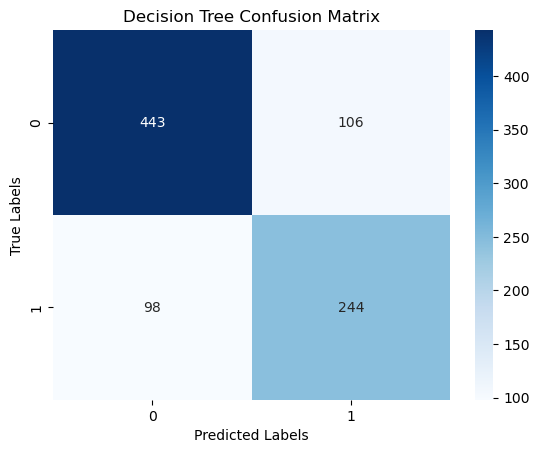

<Figure size 640x480 with 0 Axes>

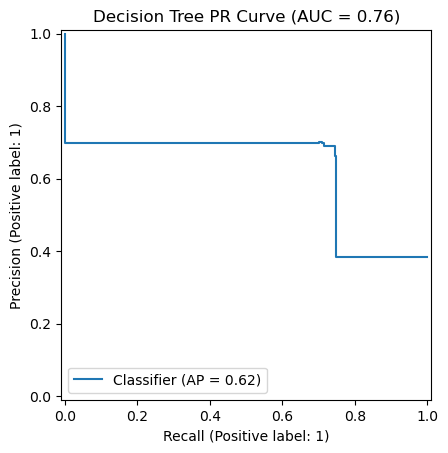

<Figure size 640x480 with 0 Axes>

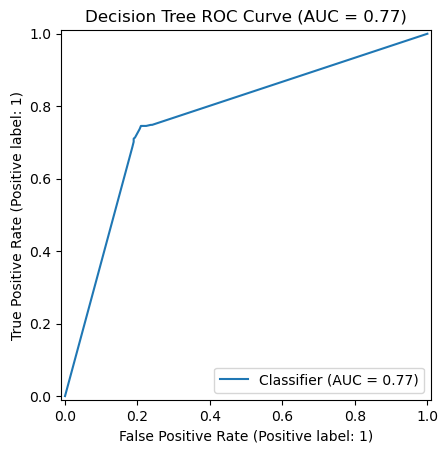


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       549
           1       0.70      0.71      0.71       342

    accuracy                           0.77       891
   macro avg       0.76      0.76      0.76       891
weighted avg       0.77      0.77      0.77       891

Random Forest K-Fold Cross-validation Accuracy: 0.8159


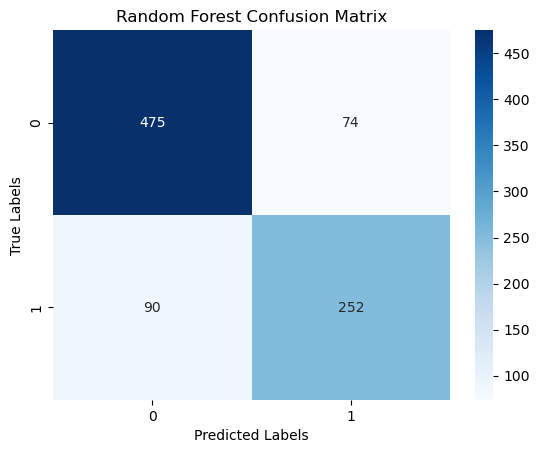

<Figure size 640x480 with 0 Axes>

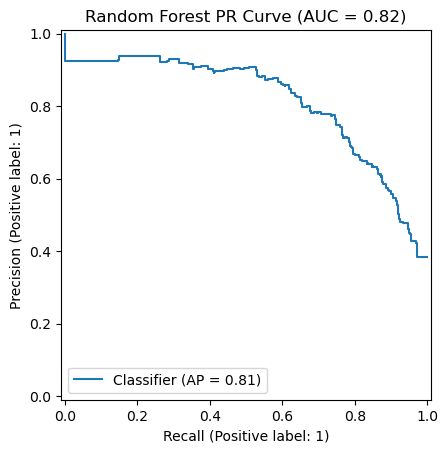

<Figure size 640x480 with 0 Axes>

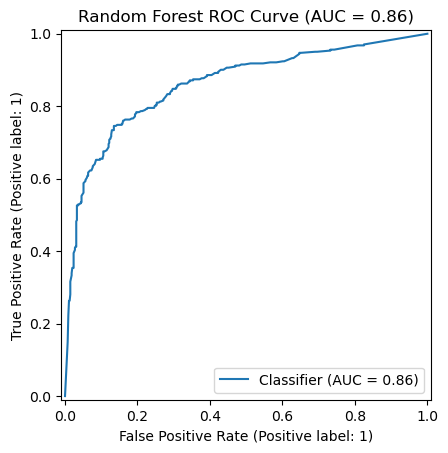


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       549
           1       0.77      0.74      0.75       342

    accuracy                           0.82       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.81      0.82      0.82       891

Gradient Boosting K-Fold Cross-validation Accuracy: 0.8272


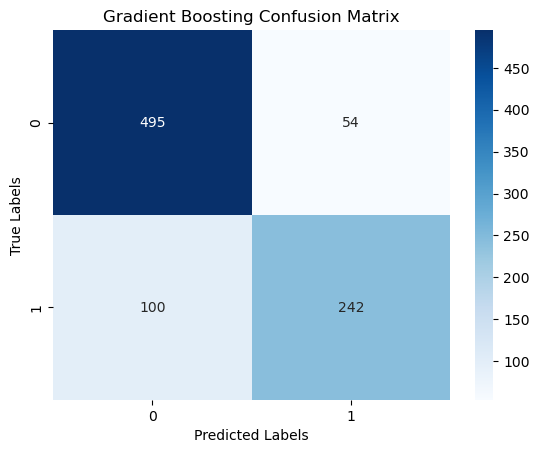

<Figure size 640x480 with 0 Axes>

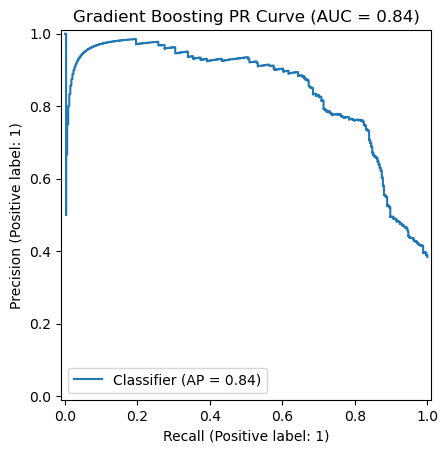

<Figure size 640x480 with 0 Axes>

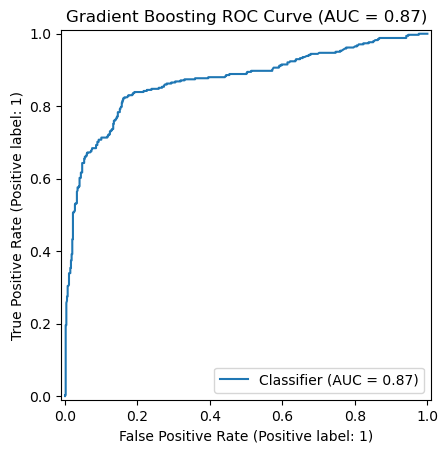


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       549
           1       0.82      0.71      0.76       342

    accuracy                           0.83       891
   macro avg       0.82      0.80      0.81       891
weighted avg       0.83      0.83      0.82       891

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

[LightGBM] [Info] Number of positive: 276, number of negative: 437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387097 -> initscore=-0.459532
[LightGBM] [Info] Start training from score -0.459532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

[LightGBM] [Info] Number of positive: 275, number of negative: 438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385694 -> initscore=-0.465448
[LightGBM] [Info] Start training from score -0.465448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


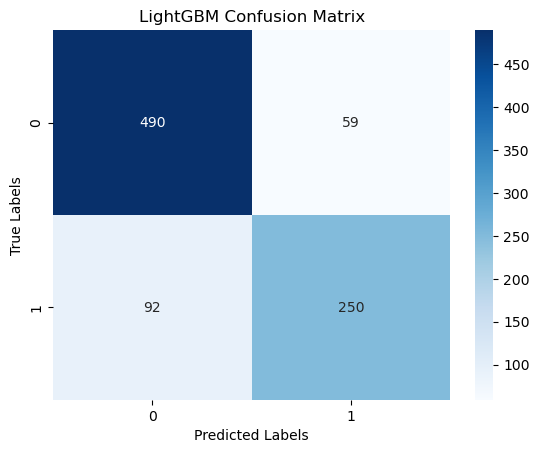

<Figure size 640x480 with 0 Axes>

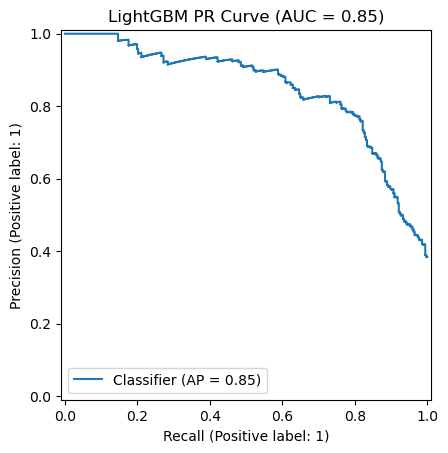

<Figure size 640x480 with 0 Axes>

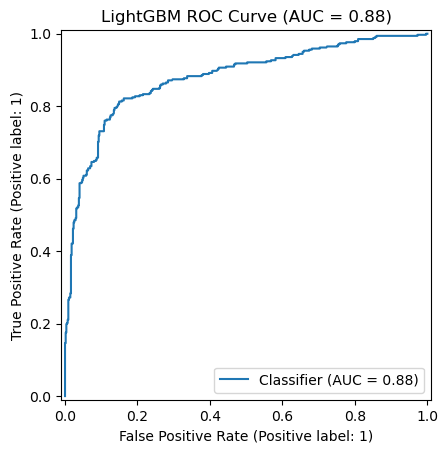


LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       549
           1       0.81      0.73      0.77       342

    accuracy                           0.83       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.83      0.83       891

CatBoost K-Fold Cross-validation Accuracy: 0.8294


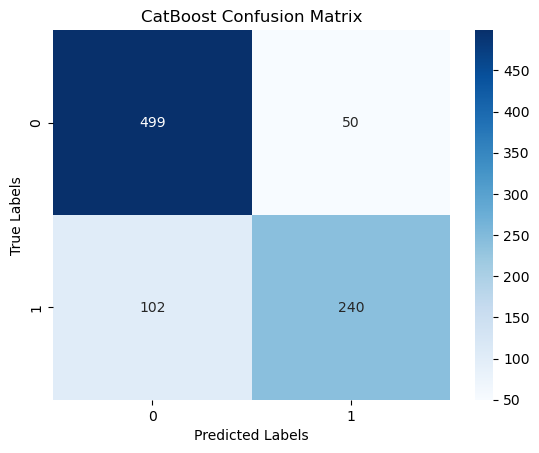

<Figure size 640x480 with 0 Axes>

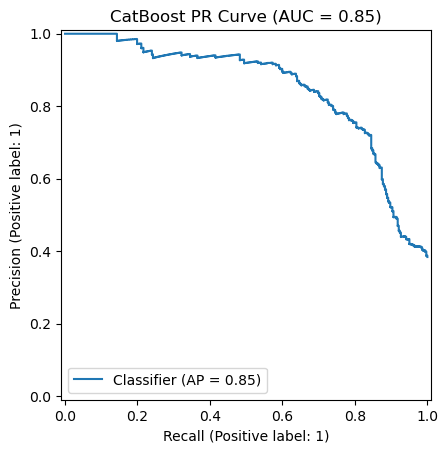

<Figure size 640x480 with 0 Axes>

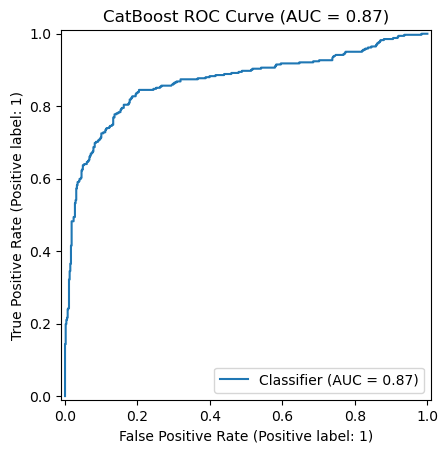


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       549
           1       0.83      0.70      0.76       342

    accuracy                           0.83       891
   macro avg       0.83      0.81      0.81       891
weighted avg       0.83      0.83      0.83       891

KNN K-Fold Cross-validation Accuracy: 0.8047


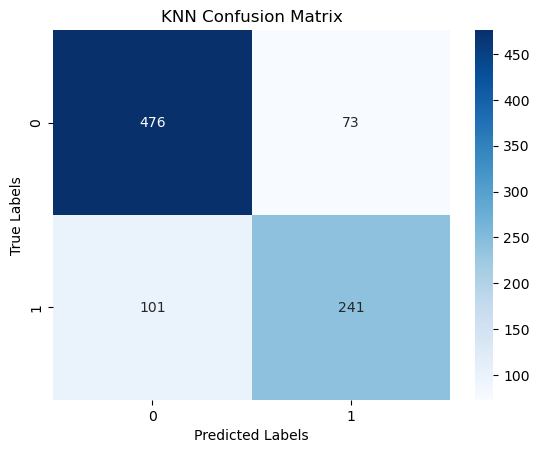

<Figure size 640x480 with 0 Axes>

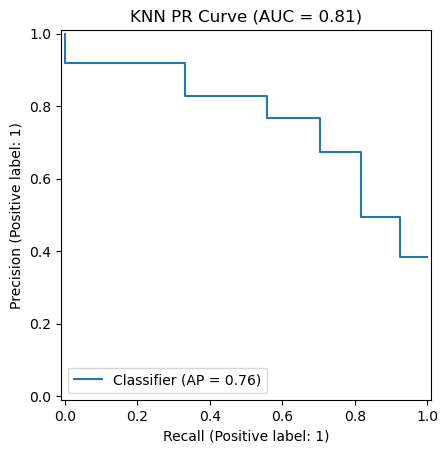

<Figure size 640x480 with 0 Axes>

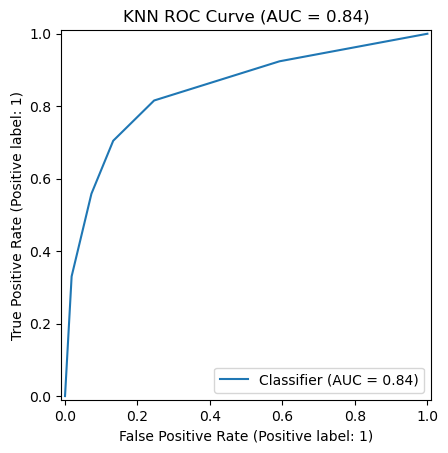


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       549
           1       0.77      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891

SVM K-Fold Cross-validation Accuracy: 0.7924


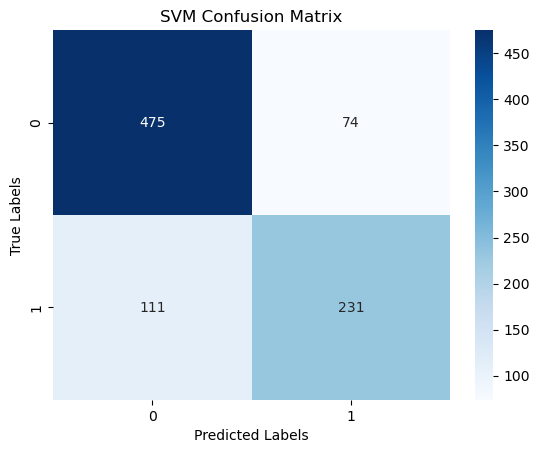

<Figure size 640x480 with 0 Axes>

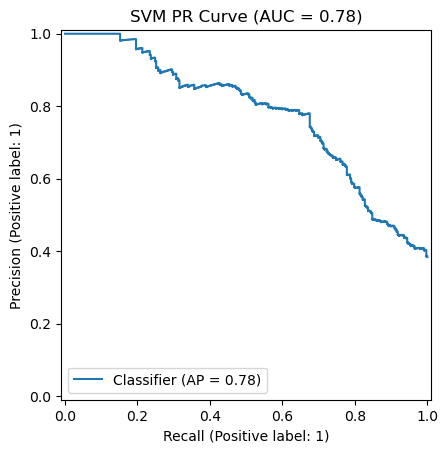

<Figure size 640x480 with 0 Axes>

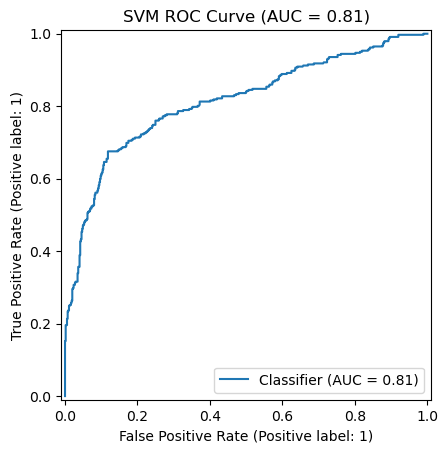


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       549
           1       0.76      0.68      0.71       342

    accuracy                           0.79       891
   macro avg       0.78      0.77      0.78       891
weighted avg       0.79      0.79      0.79       891



In [13]:
# Define K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Model list
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)  # Note: SVM needs probability=True
}

# Train and evaluate models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Initialize lists to store metrics
    all_y_test = []
    all_y_pred = []
    all_y_proba = []
    
    # Perform K-Fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Predict validation set
        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:, 1]  # Get probability for the positive class
        
        # Store results
        all_y_test.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_proba)
    
    # Combine results from all folds
    all_y_test = np.array(all_y_test)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)
    
    # Calculate cross-validation accuracy
    cv_scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
    results[name] = cv_scores.mean()
    print(f"{name} K-Fold Cross-validation Accuracy: {cv_scores.mean():.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(all_y_test, all_y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Plot PR curve
    precision, recall, _ = precision_recall_curve(all_y_test, all_y_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure()
    PrecisionRecallDisplay.from_predictions(all_y_test, all_y_proba)
    plt.title(f'{name} PR Curve (AUC = {pr_auc:.2f})')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    RocCurveDisplay.from_predictions(all_y_test, all_y_proba)
    plt.title(f'{name} ROC Curve (AUC = {roc_auc:.2f})')
    plt.show()
    
    # Output classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(all_y_test, all_y_pred))


In [41]:
# 讓用戶選擇模型
print("\n可選模型及其準確率:")
for name, score in results.items():
    print(f"{name}: {score:.4f}")

selected_model_name = input("\n請輸入要使用的模型名稱: ")

# 檢查模型是否存在
if selected_model_name not in models:
    print("錯誤：模型名稱無效！")
else:
    # 擬合整個訓練集
    selected_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models[selected_model_name])
    ])
    selected_model.fit(X, y)

    # 對測試集進行預測
    test_predictions = selected_model.predict(test_data)

    # 保存預測結果到 CSV
    submission = pd.DataFrame({
        'PassengerId': pd.read_csv('test.csv')['PassengerId'],  # 從原始測試集讀取 PassengerId
        'Survived': test_predictions
    })
    output_file = f'titanic_predictions_{selected_model_name.replace(" ", "_")}.csv'
    submission.to_csv(output_file, index=False)
    print(f"預測結果已保存為 {output_file}")


可選模型及其準確率:
Logistic Regression: 0.8047
Decision Tree: 0.7710
Random Forest: 0.8159
Gradient Boosting: 0.8272
LightGBM: 0.8306
CatBoost: 0.8294
KNN: 0.8047
SVM: 0.7924
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
預測結果已保存為 titanic_predictions_LightGBM.csv


c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
os.makedirs('saved_models', exist_ok=True)
os.makedirs('evaluation_results', exist_ok=True)

# 定義 K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 定義模型（移除 LightGBM 和 CatBoost）
model_classes = {
    "Logistic Regression": LogisticRegression,
    "Random Forest": RandomForestClassifier,
    "Gradient Boosting": GradientBoostingClassifier,
    "KNN": KNeighborsClassifier,
    "SVM": SVC
}

def create_model_objective(model_class, X, y, preprocessor, kfold):
    def objective(trial):
        if model_class.__name__ == 'LogisticRegression':
            params = {
                'C': trial.suggest_float('C', 1e-5, 1e2, log=True),
                'max_iter': trial.suggest_int('max_iter', 100, 500),
                'random_state': 42
            }
        elif model_class.__name__ == 'RandomForestClassifier':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'random_state': 42
            }
        elif model_class.__name__ == 'GradientBoostingClassifier':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'random_state': 42
            }
        elif model_class.__name__ == 'KNeighborsClassifier':
            params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                'p': trial.suggest_int('p', 1, 2)
            }
        elif model_class.__name__ == 'SVC':
            params = {
                'C': trial.suggest_float('C', 1e-5, 1e2, log=True),
                'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
                'probability': True,  # 確保 SVC 啟用機率預測
                'random_state': 42
            }
        
        model = model_class(**params)
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='f1')
        return scores.mean()
    
    return objective

# 優化和評估
optimization_results = {}
final_models = {}

for name, model_class in model_classes.items():
    print(f"\n開始優化 {name}...")

    # 進行 Optuna 參數優化
    study = optuna.create_study(direction='maximize')
    objective = create_model_objective(model_class, X, y, preprocessor, kfold)
    study.optimize(objective, n_trials=100)

    # 儲存最佳參數
    optimization_results[name] = {
        'best_params': study.best_params,
        'best_score': study.best_value
    }

    # 建立最佳模型
    best_model = model_class(**study.best_params)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', best_model)
    ])

    # 進行交叉驗證
    all_y_test = []
    all_y_pred = []
    all_y_proba = []

    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        all_y_test.extend(y_val)
        all_y_pred.extend(y_pred)

        # 檢查模型是否支援 predict_proba()
        classifier = pipeline.named_steps['classifier']
        if hasattr(classifier, "predict_proba"):
            y_proba = pipeline.predict_proba(X_val)[:, 1]
            all_y_proba.extend(y_proba)
    
    # 訓練最終模型
    pipeline.fit(X, y)
    final_models[name] = pipeline

    # 保存模型
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"{name.replace(' ', '_')}_{timestamp}"
    joblib.dump(pipeline, f'saved_models/{model_filename}.joblib')

    # 繪製並保存混淆矩陣
    cm = confusion_matrix(all_y_test, all_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'evaluation_results/{name}_confusion_matrix.png')
    plt.close()

    # 只有支援 predict_proba() 的模型才畫 ROC 和 PR 曲線
    if all_y_proba:
        plt.figure(figsize=(8, 6))
        RocCurveDisplay.from_predictions(all_y_test, all_y_proba)
        plt.title(f'{name} ROC Curve')
        plt.savefig(f'evaluation_results/{name}_roc_curve.png')
        plt.close()

        plt.figure(figsize=(8, 6))
        PrecisionRecallDisplay.from_predictions(all_y_test, all_y_proba)
        plt.title(f'{name} Precision-Recall Curve')
        plt.savefig(f'evaluation_results/{name}_pr_curve.png')
        plt.close()

# 儲存最佳參數結果
with open('saved_models/optimization_results.json', 'w') as f:
    json.dump(optimization_results, f, indent=4)

print("\n所有模型訓練和評估完成！")

[I 2025-02-04 19:07:24,791] A new study created in memory with name: no-name-97badad4-add3-4103-9182-ce651de90c90
[I 2025-02-04 19:07:24,915] Trial 0 finished with value: 0.06135816368014511 and parameters: {'C': 0.0011318603722935505, 'max_iter': 157}. Best is trial 0 with value: 0.06135816368014511.



開始優化 Logistic Regression...


[I 2025-02-04 19:07:25,046] Trial 1 finished with value: 0.022857142857142857 and parameters: {'C': 0.0007699790593475953, 'max_iter': 477}. Best is trial 0 with value: 0.06135816368014511.
[I 2025-02-04 19:07:25,163] Trial 2 finished with value: 0.7286549387708832 and parameters: {'C': 38.4603035515172, 'max_iter': 334}. Best is trial 2 with value: 0.7286549387708832.
[I 2025-02-04 19:07:25,258] Trial 3 finished with value: 0.03480010185892539 and parameters: {'C': 0.0008645744687075851, 'max_iter': 139}. Best is trial 2 with value: 0.7286549387708832.
[I 2025-02-04 19:07:25,360] Trial 4 finished with value: 0.0 and parameters: {'C': 1.5228735763223543e-05, 'max_iter': 353}. Best is trial 2 with value: 0.7286549387708832.
[I 2025-02-04 19:07:25,464] Trial 5 finished with value: 0.0 and parameters: {'C': 9.244792215344524e-05, 'max_iter': 253}. Best is trial 2 with value: 0.7286549387708832.
[I 2025-02-04 19:07:25,571] Trial 6 finished with value: 0.0 and parameters: {'C': 1.9026079819


開始優化 Random Forest...


[I 2025-02-04 19:07:37,279] Trial 0 finished with value: 0.722064611195046 and parameters: {'n_estimators': 268, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.722064611195046.
[I 2025-02-04 19:07:38,490] Trial 1 finished with value: 0.7636884331001978 and parameters: {'n_estimators': 163, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7636884331001978.
[I 2025-02-04 19:07:39,990] Trial 2 finished with value: 0.7518320951569033 and parameters: {'n_estimators': 209, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7636884331001978.
[I 2025-02-04 19:07:41,164] Trial 3 finished with value: 0.7269260793448834 and parameters: {'n_estimators': 168, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.7636884331001978.
[I 2025-02-04 19:07:42,132] Trial 4 finished with value: 0.7239633058587228 and parameters: {'


開始優化 Gradient Boosting...


[I 2025-02-04 19:10:29,912] Trial 0 finished with value: 0.7072563123467474 and parameters: {'n_estimators': 145, 'max_depth': 18, 'learning_rate': 0.037939511920041885, 'min_samples_split': 2}. Best is trial 0 with value: 0.7072563123467474.
[I 2025-02-04 19:10:35,189] Trial 1 finished with value: 0.7584362119072093 and parameters: {'n_estimators': 283, 'max_depth': 11, 'learning_rate': 0.0029622712580170164, 'min_samples_split': 15}. Best is trial 1 with value: 0.7584362119072093.
[I 2025-02-04 19:10:42,269] Trial 2 finished with value: 0.7021014860940207 and parameters: {'n_estimators': 197, 'max_depth': 18, 'learning_rate': 0.01773886696549811, 'min_samples_split': 3}. Best is trial 1 with value: 0.7584362119072093.
[I 2025-02-04 19:10:47,837] Trial 3 finished with value: 0.7382309861406366 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.08296680964013334, 'min_samples_split': 9}. Best is trial 1 with value: 0.7584362119072093.
[I 2025-02-04 19:10:54,107] T


開始優化 KNN...


[I 2025-02-04 19:14:07,782] Trial 1 finished with value: 0.7199928503770492 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.7199928503770492.
[I 2025-02-04 19:14:07,883] Trial 2 finished with value: 0.7179459663647091 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.7199928503770492.
[I 2025-02-04 19:14:07,981] Trial 3 finished with value: 0.7091004389769117 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.7199928503770492.
[I 2025-02-04 19:14:08,139] Trial 4 finished with value: 0.6985600347959285 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.7199928503770492.
[I 2025-02-04 19:14:08,232] Trial 5 finished with value: 0.6915161471721841 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.7199928503770492.
[I 2025-02-04 19:14:08,328] Trial 6 finish


開始優化 SVM...


[I 2025-02-04 19:14:19,541] Trial 0 finished with value: 0.0 and parameters: {'C': 0.00018176683222727611, 'kernel': 'linear'}. Best is trial 0 with value: 0.0.
[I 2025-02-04 19:14:19,815] Trial 1 finished with value: 0.0 and parameters: {'C': 4.1159473367804275e-05, 'kernel': 'poly'}. Best is trial 0 with value: 0.0.
[I 2025-02-04 19:14:22,593] Trial 2 finished with value: 0.7134120709972207 and parameters: {'C': 38.04203743188731, 'kernel': 'linear'}. Best is trial 2 with value: 0.7134120709972207.
[I 2025-02-04 19:14:22,882] Trial 3 finished with value: 0.06118245538136927 and parameters: {'C': 0.00543202588537978, 'kernel': 'poly'}. Best is trial 2 with value: 0.7134120709972207.
[I 2025-02-04 19:14:23,162] Trial 4 finished with value: 0.017391304347826087 and parameters: {'C': 0.000758044623848364, 'kernel': 'linear'}. Best is trial 2 with value: 0.7134120709972207.
[I 2025-02-04 19:14:23,515] Trial 5 finished with value: 0.7507598277110017 and parameters: {'C': 1.628337618845782,


所有模型訓練和評估完成！


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [22]:
import os
import joblib
import pandas as pd
from datetime import datetime

# 創建 output 目錄
os.makedirs('output', exist_ok=True)

# 讀取測試數據
X_test = test_data

# 讀取所有可用的模型 (.joblib)
saved_models_dir = 'saved_models'
available_models = {}

for filename in os.listdir(saved_models_dir):
    if filename.endswith('.joblib'):
        model_name = filename.replace('.joblib', '')  # 取得模型名稱
        available_models[model_name] = filename  # 存入字典

# 確保至少有一個模型可用
if not available_models:
    print("錯誤：未找到可用的模型！請先訓練模型。")
    exit()

# 顯示選擇的模型
print("\n可用的模型：")
for model_name in available_models.keys():
    print(f"- {model_name}")

# 進行預測並保存結果
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
submission_files = []

for model_name, filename in available_models.items():
    model_path = os.path.join(saved_models_dir, filename)
    model = joblib.load(model_path)

    # 進行預測
    predictions = model.predict(X_test)

    # 創建提交文件
    submission_filename = f'submission_{model_name}_{timestamp}.csv'
    submission_path = os.path.join('output', submission_filename)

    # 保存預測結果到 Excel
    submission = pd.DataFrame({
        'PassengerId': pd.read_csv('test.csv')['PassengerId'],
        'Survived': predictions
    })
    submission.to_csv(submission_path, index=False)
    submission_files.append(submission_filename)

# 顯示最終結果
print("\n所有模型的預測已完成！")
for file in submission_files:
    print(f"預測結果已保存：output/{file}")



可用的模型：
- Gradient_Boosting_20250204_191407
- KNN_20250204_191418
- Logistic_Regression_20250204_190735
- Random_Forest_20250204_191024
- SVM_20250204_191503

所有模型的預測已完成！
預測結果已保存：output/submission_Gradient_Boosting_20250204_191407_20250204_193831.csv
預測結果已保存：output/submission_KNN_20250204_191418_20250204_193831.csv
預測結果已保存：output/submission_Logistic_Regression_20250204_190735_20250204_193831.csv
預測結果已保存：output/submission_Random_Forest_20250204_191024_20250204_193831.csv
預測結果已保存：output/submission_SVM_20250204_191503_20250204_193831.csv


In [8]:
print("模型訓練時的特徵:", list(model.feature_names_in_))  # 需要 sklearn 1.0+
print("X_test 的特徵:", list(X_test.columns))


模型訓練時的特徵: ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']
X_test 的特徵: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
